# Import packages

In [1]:
import utils.gif as gif
import utils.ecg as ecg
import utils.binning as binning
import utils.twix as twix
import utils.svd as svd
import utils.reconstruction as reconstruction
import numpy as np

# Inputs

In [ ]:
data_path = "meas_MID00086_FID26450_DMI_PMU_250216_100rep.dat"
folder_path = "SE00078001 DMI_PMU_250216_100REP"
framerate, duration = gif.dicom_framerate_from_folder(folder_path)
# gif.print_all_dicom_info(folder_path)
n_phase_encodes_per_frame = 112
offset = 0
fs = framerate * n_phase_encodes_per_frame # Time required to acquire each phase encode
num_bins = 15  # Number of bins for binning
extended_pe_lines = 128
# ecg_columns = np.s_[18:21]
ecg_columns = np.s_[20]
sigma = 0.0886
selection = [2, 3, 4, 5, 6, 7, 8, 9]


# data_path = "20250307_JM/raw/meas_MID00115_FID27380_Cor_250306_2.dat"
# folder_path = "20250307_JM/dcm/SE00028001 COR_250306_2"
# framerate, duration = gif.dicom_framerate_from_folder(folder_path)
# # gif.print_all_dicom_info(folder_path)
# n_phase_encodes_per_frame = 48
# offset = 32 # Offset since we are doing partial fourier
# fs = framerate * n_phase_encodes_per_frame # Time required to acquire each phase encode
# num_bins = 10  # Number of bins for binning
# extended_pe_lines = 128
# ecg_columns = np.s_[18:21]
# sigma = 0.1050
# selection = [2, 4, 5, 6, 7, 8, 9]


# Example usage:
# folder_path = "20250307_JM/dcm/SE00027001 COR_250306_2"
# folder_path = "20250307_JM/dcm/SE00028001 COR_250306_2"
# framerate, duration = gif.dicom_framerate_from_folder(folder_path)
# print(duration)
# gif.print_all_dicom_info(folder_path)

# framerate, duration = gif.dicom_framerate_from_folder(folder_path)

# framerate, duration = gif.dicom_framerate_from_folder(folder_path)

# Read/extract data

In [3]:
# Read data from .dat file
twix_data = twix.read_twix_file(
    data_path,
    include_scans=[-1],
    parse_pmu=False,
)

# Extract raw kspace data
# Shape: (phase_encodes, coils, frequency_encodes)
kspace = twix.extract_image_data(twix_data)

# Extract ECG signals from the first segment
# Each ECG signal is in a separate column
ecg_data = twix.extract_iceparam_data(twix_data, segment_index=0, columns=ecg_columns)

if ecg_data.ndim == 1:
    ecg_data = ecg_data.reshape(-1, 1)


# Ensure we have the same number of phase encodes and ECG points
if kspace.shape[0] != ecg_data.shape[0]:
    raise ValueError(
        "Number of phase encodes do not match between kspace and ECG data."
    )

Software version: VD/VE (!?)

Scan  1


100%|██████████| 287M/287M [00:00<00:00, 1.17GB/s]


Successfully read 1 scans from 20250307_JM/raw/meas_MID00115_FID27380_Cor_250306_2.dat.
Extracted image data shape: (4800, 30, 256)
Extracted ICE parameter data shape: (4800, 3)


In [4]:
# filled_kspace = np.zeros((100, 128, 30, 256), dtype=kspace.dtype)
# offset = 0
# filled_kspace[:, offset:offset+112, :, :] = kspace.reshape(100, 112, 30, 256)
# gif.save_kspace_as_gif(filled_kspace, "zero_filled.gif")

# ECG processing

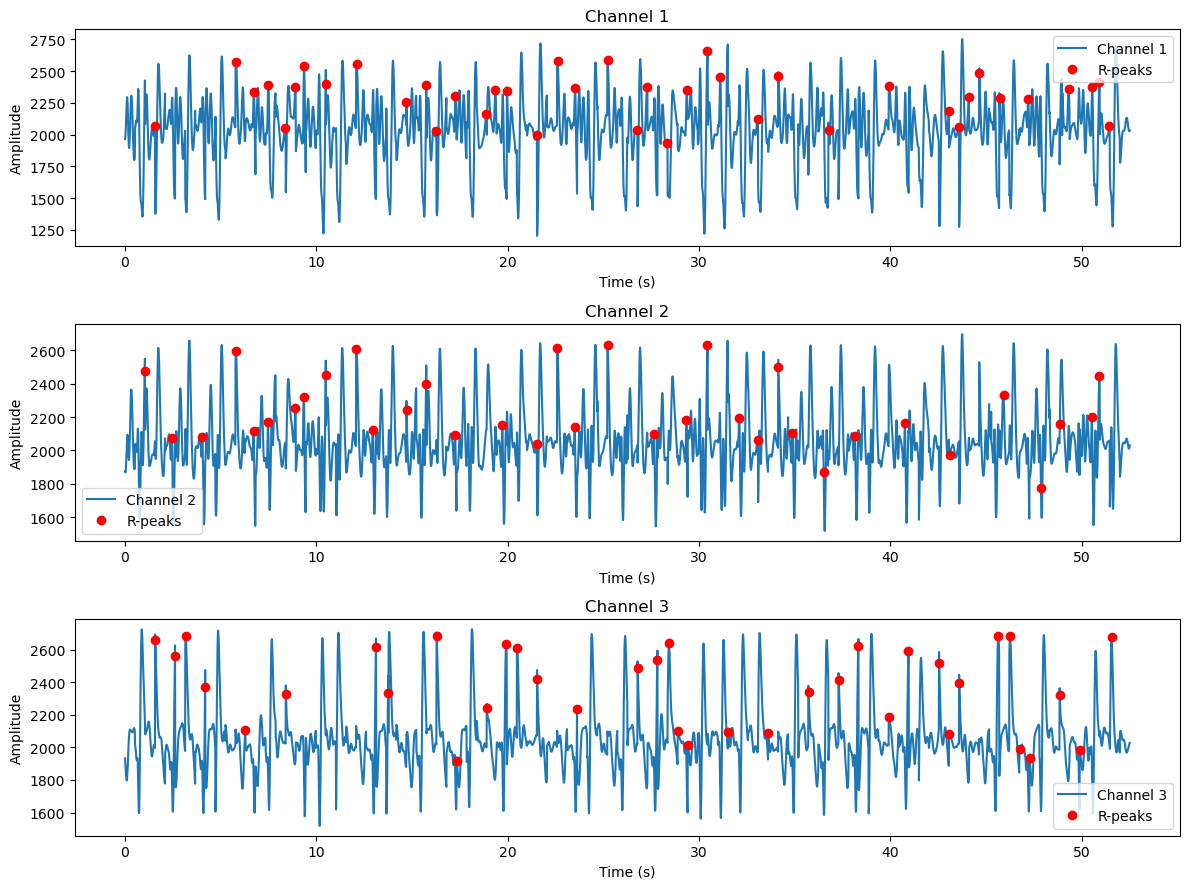

In [12]:
# Detect R-peaks across all channels.
r_peaks_list = ecg.detect_r_peaks(ecg_data, fs)

# Get average heart rate
heart_rate = ecg.average_heart_rate(r_peaks_list, fs)

# Plot ECG signals with detected peaks
# (Just to ensure that the peaks are detected correctly)
ecg.plot_ecg(ecg_data, fs, r_peaks_list, mode="separate")

In [14]:
import pandas as pd
df = pd.DataFrame(ecg_data, columns=['ch1', 'ch2', 'ch3'])
df.to_csv('ecg.csv')

# Kernel PCA on kspace

In [6]:
# print("Performing kernel PCA on k-space data...")

# # Define candidate sigma values (adjust the range as needed)
# sigma_candidates = np.logspace(-1.2, -0.5, 20)

# best_sigma, best_error, kpca, X_kspca, orig_feature_dim = svd.optimize_sigma_kpca(
#     kspace, n_phase_encodes_per_frame, sigma_candidates, n_components=None, kernel="rbf"
# )

# print(f"Best sigma: {best_sigma}, with reconstruction error: {best_error}")

In [7]:
# Perform kernel PCA on the complex k-space data.
# Note: The function now returns (kpca, X_kspca, frame_shape, orig_feature_dim)
kpca, X_kspca, frame_shape, orig_feature_dim = svd.perform_kernel_pca_kspace(
    kspace, n_phase_encodes_per_frame, kernel="rbf", sigma=sigma
)

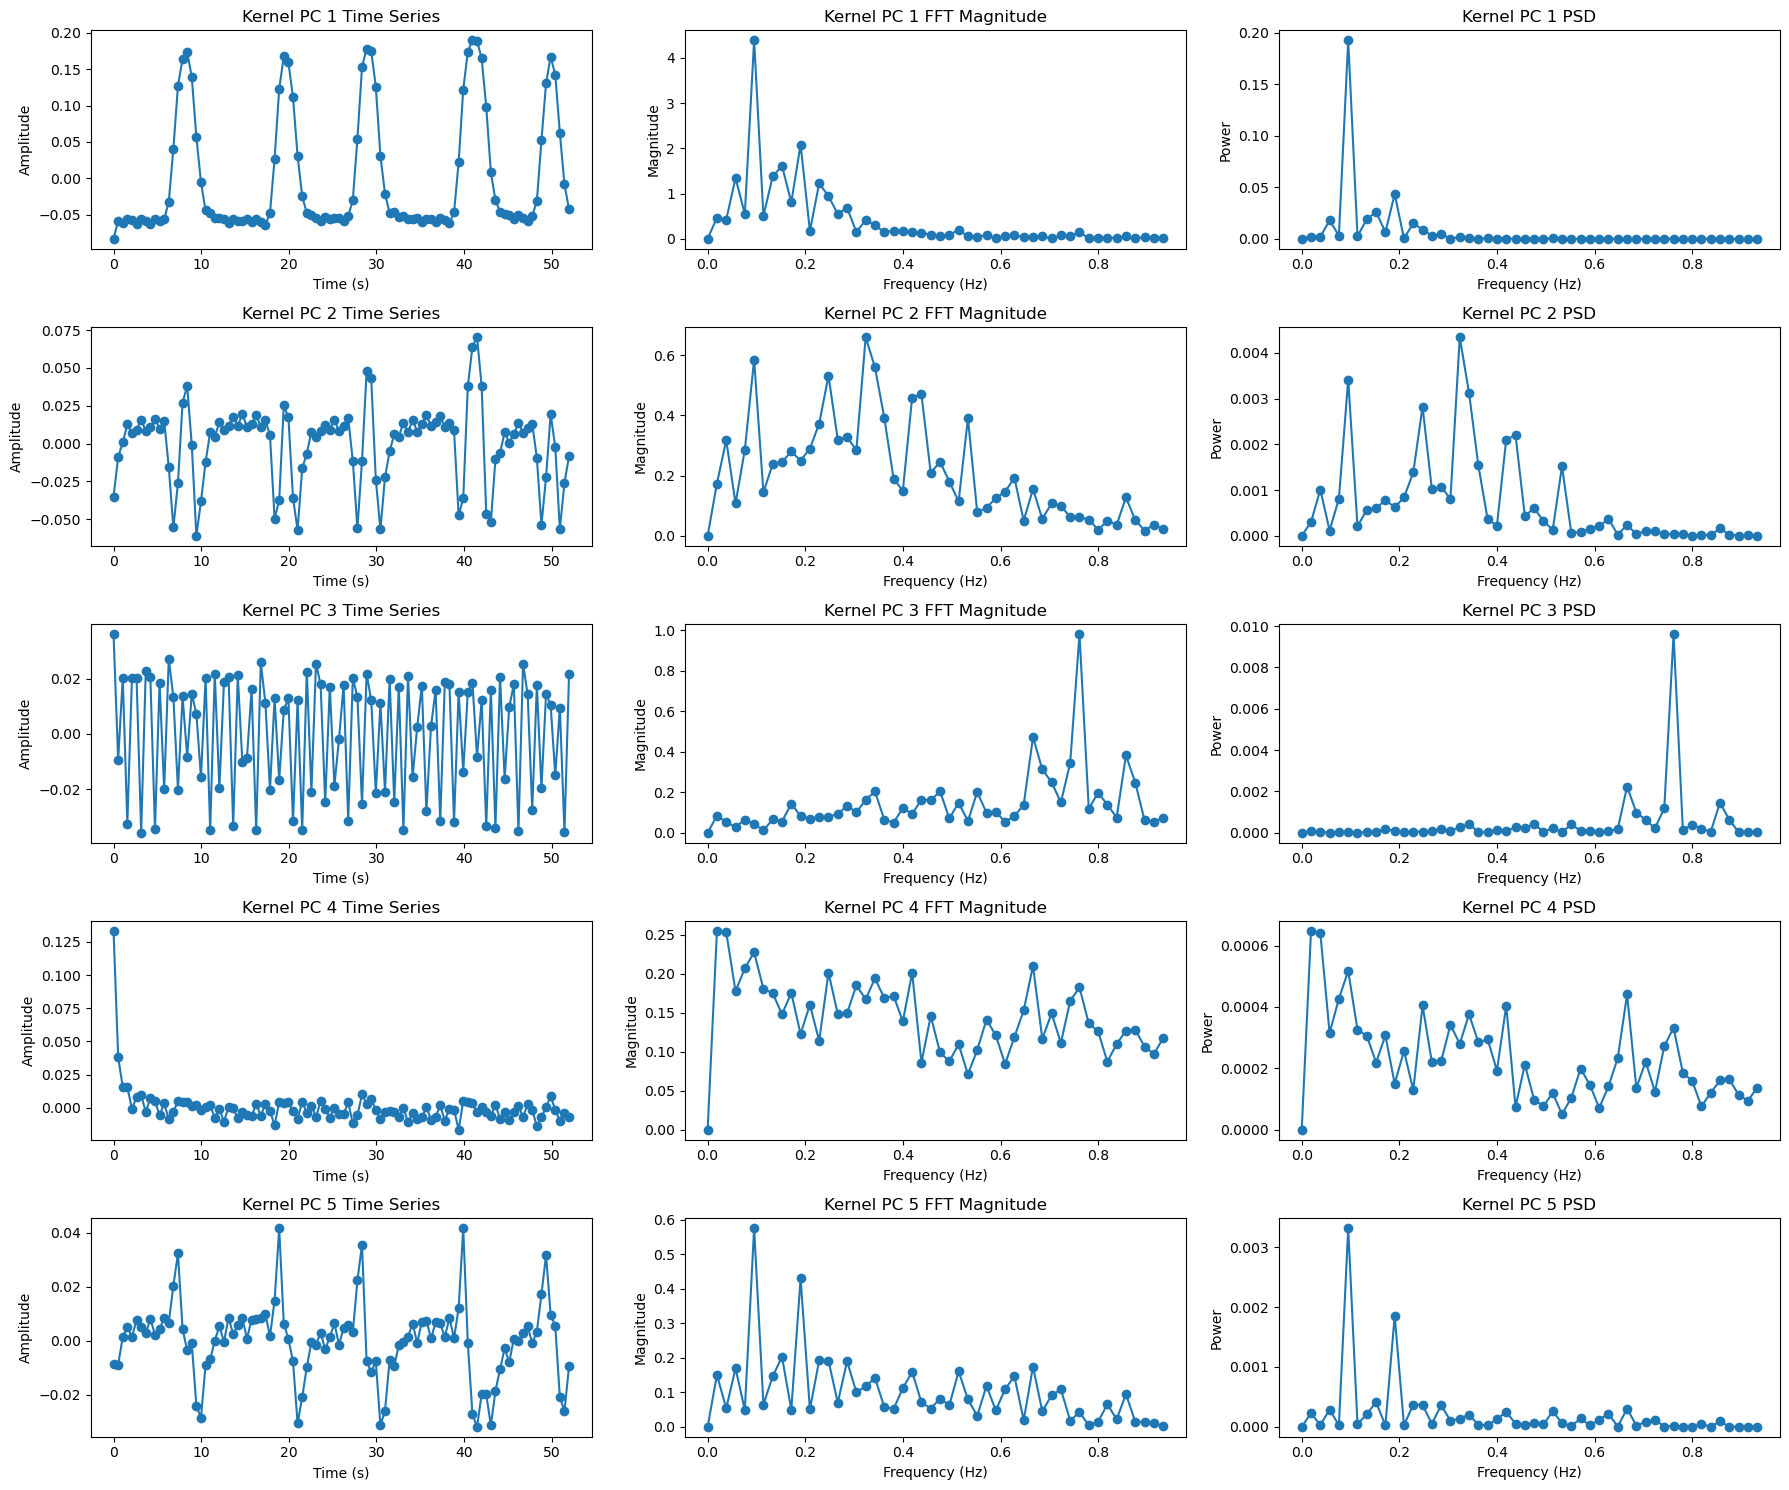

In [8]:
# Plot the first 5 kernel PCs' time series and frequency spectra.
svd.plot_kernel_pc_time_series_and_fft(
    X_kspca, sampling_rate=fs / n_phase_encodes_per_frame, n_components=5
)

In [9]:
# # Reconstruct the images from the full kernel PCA transform.
# gif.display_images_as_gif(
#     reconstruction.reconstruct_frames_kernel_kspace(kpca, X_kspca, frame_shape, orig_feature_dim)
# )

# for i in range(10):
#     gif.display_images_as_gif(
#         reconstruction.reconstruct_with_selected_components_kernel_kspace(
#             kpca, X_kspca, [i], frame_shape, orig_feature_dim
#         )
#     )

# gif.display_images_as_gif(
#         reconstruction.reconstruct_with_selected_components_kernel_kspace(
#             kpca, X_kspca, [2, 3, 4, 5, 6, 7, 8, 9], frame_shape, orig_feature_dim, extended_pe_lines, offset
#         ), interval=100
#     )

# Cardiac binning

In [10]:
X_kpca_mod = np.zeros_like(X_kspca)
X_kpca_mod[:, selection] = X_kspca[:, selection]

X_recon_real = kpca.inverse_transform(X_kpca_mod)
n_features = orig_feature_dim
X_recon_complex = X_recon_real[:, :n_features] + 1j * X_recon_real[:, n_features:]
n_frames = X_recon_complex.shape[0]
kspace_recon = X_recon_complex.reshape(
    n_frames, frame_shape[0], frame_shape[1], frame_shape[2]
)

# Perform the cardiac-phase binning
binned_data, binned_count = binning.bin_reconstructed_kspace_by_cardiac_phase_kernel(
    kpca,
    X_kspca,
    selection,
    frame_shape,
    orig_feature_dim,
    r_peaks_list,
    num_bins=num_bins,
    n_phase_encodes_per_frame=n_phase_encodes_per_frame,
    extended_pe_lines=extended_pe_lines,
    offset=offset
)
print("Binned k-space shape:", binned_data.shape)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 40 and the array at index 1 has size 35

# Reconstructing binned cine

In [ ]:
# Homodyne reconstruction of the binned data.
homodyne_recon_images = reconstruction.homodyne_binned_data(binned_data, binned_count)
print("Homodyne reconstructed images shape:", homodyne_recon_images.shape)

# Crop/rotate/flip images
homodyne_recon_images = np.rot90(homodyne_recon_images, k=1, axes=(1, 2))
homodyne_recon_images = np.flip(homodyne_recon_images, axis=2)
homodyne_recon_images = homodyne_recon_images[:, 64:-64, :]

# Save the reconstructed images as a GIF.
gif.save_images_as_gif(
    homodyne_recon_images, "homodyne_binned_cine.gif", duration=1000 * 60 / heart_rate / num_bins
)

gif.save_kspace_as_gif(binned_data, "binned_kspace.gif", duration=60 / heart_rate / num_bins, cmap="gray")

# Display the reconstructed images as an animated GIF.
gif.display_images_as_gif(homodyne_recon_images, interval=1000 * 60 / heart_rate / num_bins)

Homodyne reconstructed images shape: (20, 128, 256)
Saved GIF to homodyne_binned_cine.gif
Saved k-space GIF to binned_kspace.gif
